# Multi-Convolutional Sentiment Classifier

We are going to classify IMDB reviews by their sentiment with a *Multi-ConvNet*

#### Load dependencies

In [6]:
import keras
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, concatenate
from keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv1D, SpatialDropout1D, GlobalMaxPooling1D
from keras.layers import Embedding
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#### Set hyperparameters

In [7]:
output_dir = 'model_output/multi_conv'

epochs = 4
batch_size =128

n_dim = 64
n_unique_words= 5000
n_words_to_skip = 50
max_review_length = 400
pad_type = trunc_type = 'pre'
drop_embed = 0.2

#Con layer
n_conv_1 = n_conv_2= n_conv_3 = 256
k_conv_1 = 3
k_conv_2 = 2
k_conv_3 = 4

#Dense layer
n_dense = 256
dropout = 0.25


#### Load data

In [8]:
(x_train, y_train) , (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words)

#### Preprocess data

In [9]:
x_train_1 = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, 
                        truncating=trunc_type,value=0)
x_valid_1 = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, 
                        truncating=trunc_type,value=0)

In [31]:
input_layer = Input(shape=(max_review_length,),dtype='int16',name='input')

embedding_layer = Embedding(n_unique_words, n_dim, input_length=max_review_length,
                           name='embedding')(input_layer)
drop_embed_layer = SpatialDropout1D(drop_embed, name='drop_embed')(embedding_layer)


conv_1 = Conv1D(n_conv_1, k_conv_1, activation='relu', name='conv_1')(drop_embed_layer)
maxp_1 = GlobalMaxPooling1D(name='maxp_1')(conv_1)

conv_2 = Conv1D(n_conv_2, k_conv_2, activation='relu', name='conv_2')(drop_embed_layer)
maxp_2 = GlobalMaxPooling1D(name='maxp_2')(conv_2)

conv_3 = Conv1D(n_conv_3, k_conv_3, activation='relu', name='conv_3')(drop_embed_layer)
maxp_3 = GlobalMaxPooling1D(name='maxp_3')(conv_3)

concat = concatenate([maxp_1, maxp_2, maxp_3])

dense_layer = Dense(n_dense, activation='relu', name='dense_1')(concat)
drop_dense_layer = Dropout(dropout, name='drop_dense')(dense_layer)

dense_layer_2 = Dense(n_dense, activation='relu', name='dense_2')(drop_dense_layer)
drop_dense_layer_2 = Dropout(dropout, name='drop_dense_2')(dense_layer_2)

predictions= Dense(1, activation='sigmoid', name='output')(drop_dense_layer_2)

model = Model(input_layer, predictions)

In [32]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 400)          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 400, 64)      320000      input[0][0]                      
__________________________________________________________________________________________________
drop_embed (SpatialDropout1D)   (None, 400, 64)      0           embedding[0][0]                  
__________________________________________________________________________________________________
conv_1 (Conv1D)                 (None, 398, 256)     49408       drop_embed[0][0]                 
__________________________________________________________________________________________________
conv_2 (Co

In [33]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
model_checkpoint =  ModelCheckpoint(filepath=output_dir+"weights.{epoch:02d}.hdf5")

In [35]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

#### Train!

In [36]:
model.fit(x_train_1, y_train, batch_size=batch_size, epochs=epochs, verbose=1,
         validation_data=(x_valid_1,y_valid), callbacks=[model_checkpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/4
25000/25000 [==============================] - 460s 18ms/step - loss: 0.4984 - acc: 0.7203 - val_loss: 0.2901 - val_acc: 0.8786
Epoch 2/4
25000/25000 [==============================] - 440s 18ms/step - loss: 0.2465 - acc: 0.9022 - val_loss: 0.2577 - val_acc: 0.8936
Epoch 3/4
25000/25000 [==============================] - 428s 17ms/step - loss: 0.1748 - acc: 0.9336 - val_loss: 0.2777 - val_acc: 0.8886
Epoch 4/4
25000/25000 [==============================] - 474s 19ms/step - loss: 0.1231 - acc: 0.9567 - val_loss: 0.2963 - val_acc: 0.8885


#### Evaluate

In [37]:
model.load_weights(output_dir+'weights.02.hdf5')

In [38]:
y_hat = model.predict(x_valid_1)

In [39]:
y_hat[0]

array([0.04114167], dtype=float32)

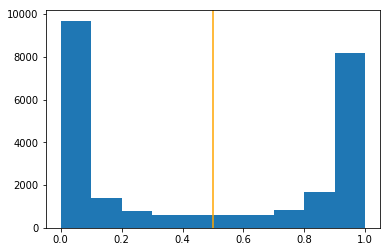

In [40]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [41]:
pct_auc = roc_auc_score(y_valid, y_hat)*100.0

In [42]:
"{:0.2f}".format(pct_auc)

'96.15'